<a href="https://colab.research.google.com/github/B21-CAP0366/meater-ml/blob/main/meater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Meater

Steps:
1. Acquire data
1. Data preprocessing
1. Make the model
1. Train the model
1. Plot the model
1. Save the model

## Acquire Data

Acquire data from: https://www.kaggle.com/crowww/meat-quality-assessment-based-on-deep-learning

Steps:
1. Run cells below
1. Upload `kaggle.json` to colab
1. Done. It will be downloaded to your workspace automatically

In [1]:
# Import libraries
from glob import glob
from google.colab import files
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import json
import os
import requests
import shutil
import tempfile
import zipfile

In [2]:
print("Upload your kaggle.json")
kaggle_file = files.upload()

# Change file permission
! chmod 600 kaggle.json 
# Check or make kaggle folder
! (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle)
# Move kaggle.json to kaggle folder
! mv kaggle.json ~/.kaggle/ && echo 'Done'
# Download dataset from kaggle
! kaggle datasets download crowww/meat-quality-assessment-based-on-deep-learning

file_name = 'meat-quality-assessment-based-on-deep-learning.zip'
# Extract dataset zip file
with zipfile.ZipFile(file_name) as zip_file:
    zip_file.extractall('./meat-dataset/')

print('Done')

Upload your kaggle.json


Saving kaggle.json to kaggle.json
Done
 97% 261M/270M [00:03<00:00, 73.6MB/s]
100% 270M/270M [00:03<00:00, 77.7MB/s]
Done


## Data Preprocessing

In [3]:
base_dir = 'meat-dataset'
fresh_dir = os.path.join(base_dir, 'Fresh')
spoiled_dir = os.path.join(base_dir, 'Spoiled')

fresh = glob(fresh_dir + '/*.jpg')
spoiled = glob(spoiled_dir + '/*.jpg')

print("Fresh  : {}".format(len(fresh)))
print("Spoiled: {}".format(len(spoiled)))

Fresh  : 948
Spoiled: 948


### Look at the data

Show images of fresh and spoiled meats

In [4]:
def display_images(paths, rows, cols, title = None):
    """
    Plot images depends on how many paths will be given

    Parameters
    ----------
    paths: list of str
        List of image paths
    rows: int
        Number of rows in the plot
    cols: int
        Number of columns in the plot
    title: string
        The title of the image
    """

    fig, ax = plt.subplots(rows, cols, figsize=(16, 12))
    ax = ax.flatten()

    # Set the title's color
    if title == 'Fresh':
        color = 'green'
    elif title == 'Spoiled':
        color = 'red'

    for i, path in enumerate(paths):
        img = cv.imread(path)
        # Convert to RGB color
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB) 

        ax[i].set_title("{}-{}".format(title, img.shape), color=color)
        ax[i].imshow(img)
        ax[i].grid(False)
        ax[i].axis(False)
    
    plt.tight_layout()
    plt.show()

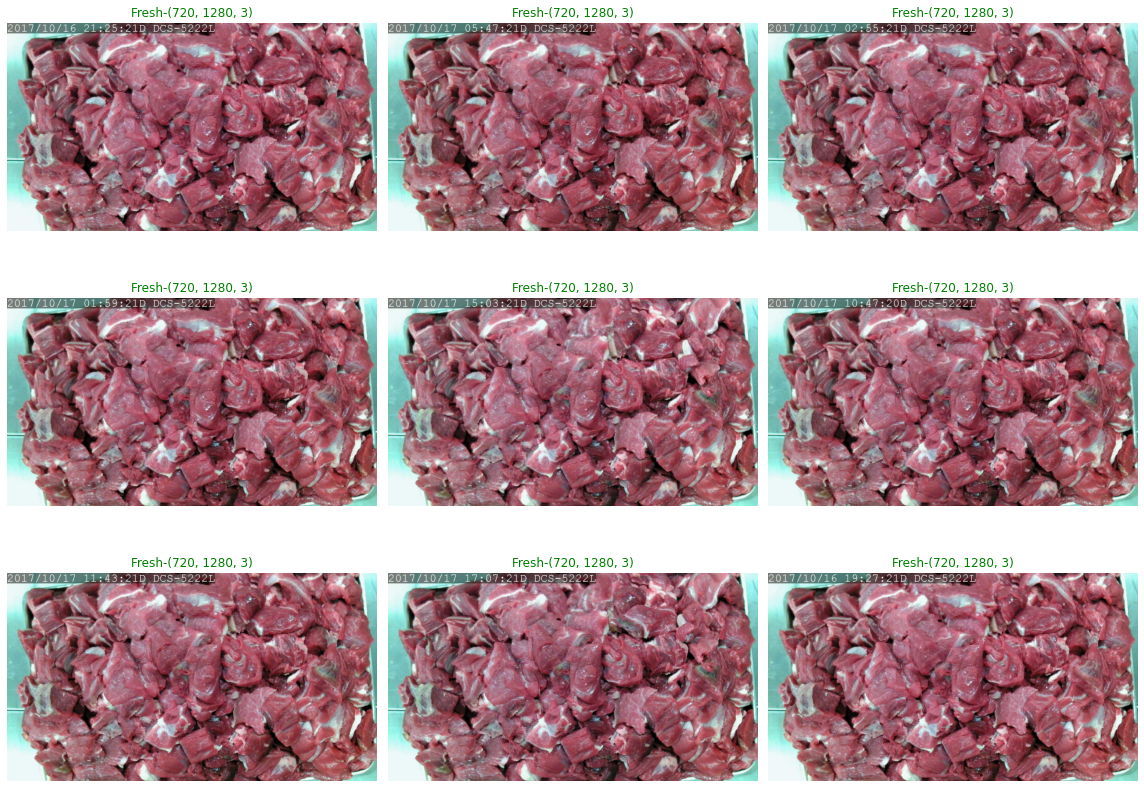

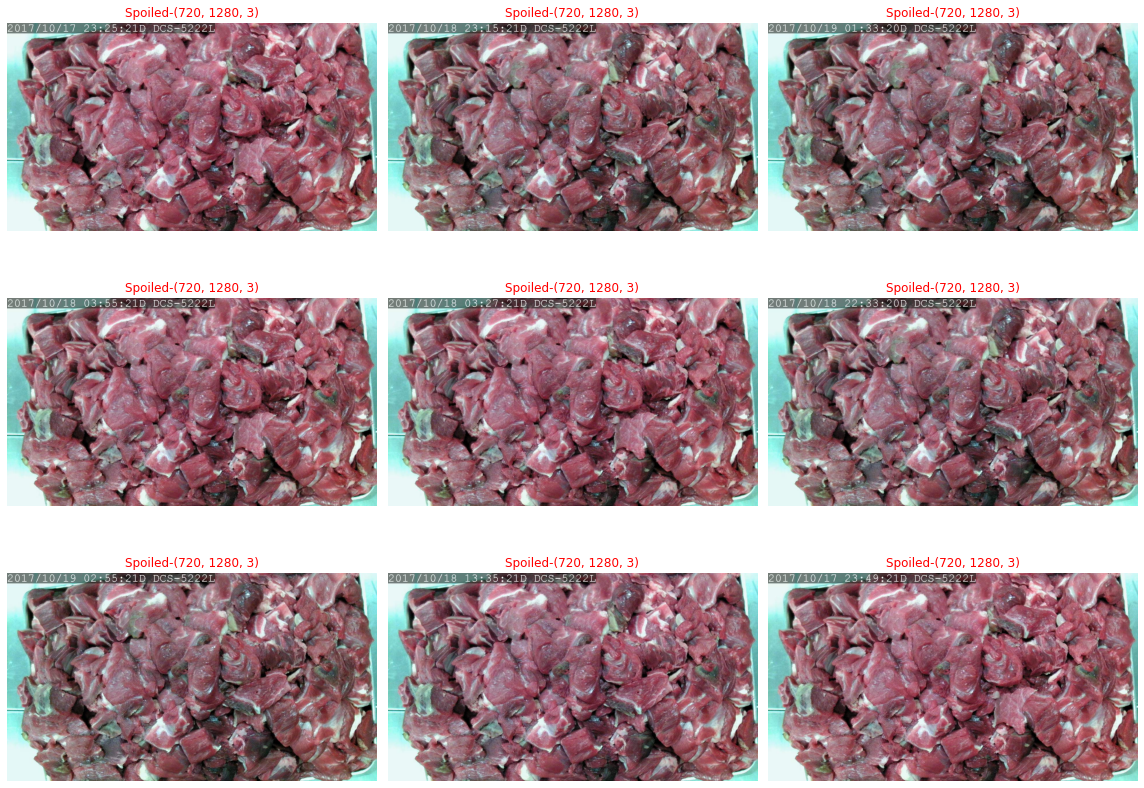

In [5]:
# Show fresh images
fresh_paths = np.random.choice(fresh, 9)
display_images(fresh_paths, rows=3, cols=3, title='Fresh')

# Show spoiled images
spoiled_paths = np.random.choice(spoiled, 9)
display_images(spoiled_paths, rows=3, cols=3, title='Spoiled')

### Make dataframe

Make dataframe with `image` as feature and `target` as target. 
* `image` will be the image's path
* `target` will be the image's target. 0 = Fresh, 1 = Spoiled


In [6]:
df = pd.DataFrame(columns=['image', 'target'])
df['image'] = fresh + spoiled
df['target'] = df['image'].apply(lambda x: 0 if 'Fresh' in x else 1)
df = df.sample(frac=1).reset_index(drop=True)

labels = ['Fresh', 'Spoiled']
df.head()

image  target
0    meat-dataset/Fresh/test_20171016_210321D.jpg       0
1    meat-dataset/Fresh/test_20171017_084121D.jpg       0
2    meat-dataset/Fresh/test_20171016_230921D.jpg       0
3  meat-dataset/Spoiled/test_20171018_053521D.jpg       1
4  meat-dataset/Spoiled/test_20171018_115321D.jpg       1

### Train, val, test split

Total data: 948 + 948 = 1896

Type       | Percentage | Numbers |
-----------|------------|---------|
Train      |        80% |    1516 |
Validation |        15% |     284 |
Test       |         5% |      96 |
**Total**  |   **100%** |**1896** |

In [7]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=43, stratify=df['target'])
val_df, test_df = train_test_split(test_df, test_size=0.25, random_state=43, stratify=test_df['target'])

print("Train: {}".format(train_df.shape))
print("Fresh  : {}".format(train_df[train_df['target'] == 1].shape[0]))
print("Spoiled: {}".format(train_df[train_df['target'] == 0].shape[0]))

print("\nVal: {}".format(val_df.shape))
print("Fresh  : {}".format(val_df[val_df['target'] == 1].shape[0]))
print("Spoiled: {}".format(val_df[val_df['target'] == 0].shape[0]))

print("\nTest : {}".format(test_df.shape))
print("Fresh  : {}".format(test_df[test_df['target'] == 1].shape[0]))
print("Spoiled: {}".format(test_df[test_df['target'] == 0].shape[0]))

Train: (1516, 2)
Fresh  : 758
Spoiled: 758

Val: (285, 2)
Fresh  : 143
Spoiled: 142

Test : (95, 2)
Fresh  : 47
Spoiled: 48


In [8]:
val_df.head()

image  target
107     meat-dataset/Fresh/test_20171017_162721D.jpg       0
1378  meat-dataset/Spoiled/test_20171018_190521D.jpg       1
214   meat-dataset/Spoiled/test_20171019_015521D.jpg       1
9       meat-dataset/Fresh/test_20171017_175321D.jpg       0
1719  meat-dataset/Spoiled/test_20171017_231521D.jpg       1

### Image preprocessing

Image will be:
1. Normalized, so the range value is 0-1
1. Resized to desired dimension (256 x 256)

Image will be augmented:
1. Random flip left or right
1. Random flip up or down
1. Random brightness
1. Random contrast

In [9]:
dim = 256

def decode_image(filename, label=None, image_size=(dim, dim)):
    """
    Decode, normalize, and resize the image

    Parameters
    ----------
    filename: str
        The image file's name
    label: int, optional
        The image's label (default is None)
    image_size: tuple of int, optional
        The image's size. (default is (256, 256))

    Returns
    -------
    image:
        Decoded image
    label: optional
        One-hot encoded label
    """

    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32)  # Convert to float32
    image /= 255.0  # Normalize
    image = tf.image.resize(image, image_size)  #Resize
    
    if label == None:
        return image
    else:
        return image, tf.one_hot(label, depth=len(labels))

def image_augment(image, label=None):
    """
    Augment the image.
    The image will randomly flip left, right, up, or down
    The image will be given random brightness and contrast

    Parameters
    ----------
    image: tf.image
        The image
    label: list, optional
        One-hot encoded label (default is None)

    Returns
    -------
    image:
        Augmented image
    label: optional
        One-hot encoded label
    """

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, lower = 0.3, upper = 0.9)

    if label == None:
        return image
    else: 
        return image, label

In [10]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_df['image'], train_df['target']))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(image_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

val_dataset = (
    tf.data.Dataset
    .from_tensor_slices((val_df['image'], val_df['target']))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_df['image'], test_df['target']))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [11]:
for img, label in train_dataset.take(1):
    print("Image shape: {}".format(img.numpy().shape))
    print("Label shape: {}".format(label.numpy().shape))

Image shape: (16, 256, 256, 3)
Label shape: (16, 2)


In [12]:
def plot_dataset(dataset, rows, cols):
    """
    Plot dataset

    Parameters
    ----------
    dataset: tf.data.Dataset
        Dataset that has been processed
    rows: int
        Number of rows in plot
    cols: int 
        Number of columns in plot
    """
    for img, label in train_dataset.take(1):
        for i in range(rows*cols):
            ax = plt.subplot(rows, cols, i+1)
            plt.imshow(img[i].numpy())

            # Set the title's color
            if labels[np.argmax(label[i].numpy())] == 'Fresh':
                color = 'green'
            elif labels[np.argmax(label[i].numpy())] == 'Spoiled':
                color = 'red'

            plt.title(labels[np.argmax(label[i].numpy())], color=color)
            plt.axis('off')
            plt.grid(False)

        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


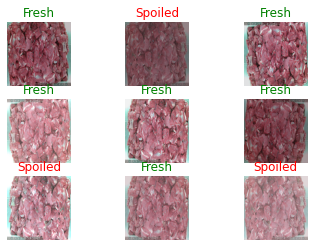

In [13]:
plot_dataset(train_dataset, 3, 3)

## Model

### Plot the model

Function of plotting the model
1. Confusion plot
1. History plot

In [14]:
def confusion_plot(model, labels=labels):
    """
    Plot confusion matrix of the trained model and 
    show classification report

    Parameters
    ----------
    model: tf.keras.models.Sequential
        Trained model
    labels: list of str
        List of labels (default is ['Fresh', 'Spoiled'])
    """

    predict = model.predict(test_dataset)
    y_true = test_df['target'].values
    y_pred = np.argmax(predict, axis=1)

    confusion = confusion_matrix(y_true, y_pred)
    c_report = classification_report(y_true, y_pred, target_names=labels)

    print("Classification report")
    print(c_report)

    sns.heatmap(confusion, annot=True, cbar=False)
    plt.xticks(np.arange(len(labels)) + 0.5, labels, rotation=0)
    plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def plot_result(train_data, val_data, title, xlabel, ylabel):
    """
    Plot training and validation data

    Parameters
    ----------
    train_data: list
        The history of training data
    val_data: list
        The history of validation data
    title: str
        The title of the plot
    xlabel: str
        X axis label
    ylabel: str
        Y axis label
    """

    x = range(len(train_data))
    plt.plot(x, train_data, 'r-')
    plt.plot(x, val_data, 'b-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(['Train', 'Validation'])

def plot_history(history):
    """
    Plot the history of accuracy and loss of the model

    Parameters
    ----------
    history:
        The trained model
    """

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    x_label = 'Epochs'

    plot_result(loss, val_loss, 'Loss', x_label, 'Loss')
    plt.figure()
    plot_result(acc, val_acc, 'Accuracy', x_label, 'Accuracy')

In [15]:
# Make callbacks
DESIRED_VAL_ACC = 0.99
DESIRED_ACC = 0.99

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if(logs.get('accuracy') > DESIRED_ACC and 
           logs.get('val_accuracy') > DESIRED_VAL_ACC):
           print("\nYour accuracy has reached {}\nYour val acc has reached {}".format(
               DESIRED_ACC, DESIRED_VAL_ACC))
           self.model.stop_training = True

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  mode='min',
                                                  patience=4,
                                                  verbose=1)

my_callback = MyCallback()

steps_per_epoch = len(train_df) // BATCH_SIZE

### Train the Model

Train the model using CNN model without fine tuning

Specifications:
1. Optimizer: Adam
1. Loss: Binary Crossentropy
1. Metrics: Accuracy
1. Epochs: 15
1. Callbacks: Early Stopping

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=(dim, dim, 3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(labels), activation='sigmoid')
])

do_fine_tuning = False #@param {type:"boolean"}

if do_fine_tuning:
    optimizer = tf.keras.optimizers.SGD(lr=0.002, momentum=0.9)
else:
    optimizer = "adam"

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Train the model
EPOCHS = 15

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    callbacks=[early_stopping]
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

In [ ]:
model.summary()

{'loss': 0.01072735246270895, 'accuracy': 1.0}


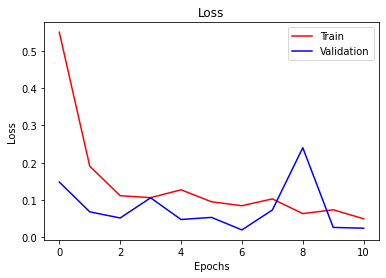

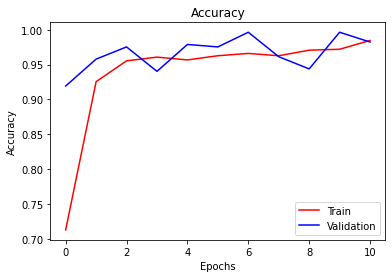

In [ ]:
ev = model.evaluate(test_dataset, return_dict=True, verbose=0)
print(ev)
plot_history(history)

Classification report
              precision    recall  f1-score   support

       Fresh       1.00      1.00      1.00        48
     Spoiled       1.00      1.00      1.00        47

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95



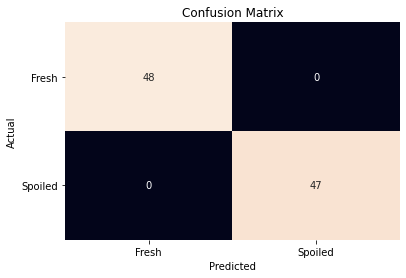

In [ ]:
confusion_plot(model1)

### Save the model

Save the model to TFLite format and download the model and labels file

In [ ]:
MODEL_DIR = tempfile.gettempdir()

version = 1

export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

model1.save(export_path, save_format="tf")

print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}

INFO:tensorflow:Assets written to: /tmp/1/assets

export_path = /tmp/1
total 216
drwxr-xr-x 2 root root   4096 May 20 04:04 assets
-rw-r--r-- 1 root root 210316 May 20 04:04 saved_model.pb
drwxr-xr-x 2 root root   4096 May 20 04:04 variables


In [ ]:
# Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

# Set the optimization strategy for 'size' in the converter 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

# Use the tool to finally convert the model
tflite_model = converter.convert()

# Write TFLite model
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

with open('labels.txt', 'w') as f:
    f.write('\n'.join(labels))

In [ ]:
try:
    files.download('converted_model.tflite')
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Test the Model

### Testing

Choose a random image in test dataframe and test it on TFLite model and TensorFlow model

In [ ]:
test_df.head()

image  target
1614    meat-dataset/Fresh/test_20171016_163721D.jpg       0
1696    meat-dataset/Fresh/test_20171016_185321D.jpg       0
487     meat-dataset/Fresh/test_20171017_175921D.jpg       0
445     meat-dataset/Fresh/test_20171017_080921D.jpg       0
1875  meat-dataset/Spoiled/test_20171018_002521D.jpg       1

In [ ]:
# Take test images
random_image = np.random.choice(test_df['image'], 3)

print('Random image: {}'.format(random_image))

Random image: ['meat-dataset/Fresh/test_20171016_114921D.jpg'
 'meat-dataset/Fresh/test_20171017_180121D.jpg'
 'meat-dataset/Spoiled/test_20171018_193521D.jpg']


#### TFLite Model

Steps:
1. Load the TFLite model
1. Make an interpreter
1. Make input and output index
1. Load the test image
1. Convert the image to array
1. Make to 4-dimensional array
1. Set tensor in interpreter (Input image)
1. Predict the image by invoke the interpreter
1. Get tensor in interpreter (Get predicted value)

In [ ]:
# Load TFLite model and allocate tensors.
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()
    
# Make an interpreter
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
# Gather results for the randomly sampled test images
predictions = []

for test_path in random_image:
    img = tf.keras.preprocessing.image.load_img(test_path, target_size=(dim, dim))

    # Image to array
    x = tf.keras.preprocessing.image.img_to_array(img)
    # Make to 4-dimensional array
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])

    # Predict image
    interpreter.set_tensor(input_index, images)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))

for prediction in predictions:
    print(prediction)

[[1.000000e+00 4.156028e-39]]
[[1.000000e+00 4.156028e-39]]
[[4.156028e-39 1.000000e+00]]


#### TF Model

Steps
1. Load the test image
1. Convert the image to array
1. Make to 4-dimensional array
1. Make the data into JSON format
1. POST it to the server
1. The server will give prediction value

##### Update system

Update the system to get the server to test the model in TensorFlow format. (Note: TFLite format doesn't need this server)

In [ ]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  30340      0 --:--:-- --:--:-- --:--:-- 30340
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Re

In [ ]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 72 not upgraded.
Need to get 326 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.5.1 [326 MB]
Fetched 326 MB in 5s (62.2 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.5.1_all.deb ...
Unpacking tensorflow-model-server (2.5.1) ...
Setting up tensorflow-model-server (2.5.1) ...


##### Prepare the Server

Prepare the server to test the model in TensorFlow format. (Note: TFLite format doesn't need this server)

In [ ]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['conv2d_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 256, 256, 3)
        name: serving_default_conv2d_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 2)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0520 02:50:03.951977 139960561424256 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/py

In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=meater \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 2 in a separate thread.


In [ ]:
!tail server.log

2021-05-20 02:52:27.406206: I tensorflow_serving/model_servers/server_core.cc:486] Finished adding/updating models
2021-05-20 02:52:27.406277: I tensorflow_serving/model_servers/server.cc:367] Profiler service is enabled
2021-05-20 02:52:27.406719: I tensorflow_serving/model_servers/server.cc:393] Running gRPC ModelServer at 0.0.0.0:8500 ...
[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 230] NET_LOG: Couldn't bind to port 8501
[evhttp_server.cc : 63] NET_LOG: Server has not been terminated. Force termination now.
[evhttp_server.cc : 265] NET_LOG: Server is not running ...
2021-05-20 02:52:27.407754: E tensorflow_serving/model_servers/server.cc:416] Failed to start HTTP Server at localhost:8501
                                                                                                                                                                                                                                                                   20

##### Test

In [ ]:
for test_path in random_image:
    img = tf.keras.preprocessing.image.load_img(test_path, target_size=(dim, dim))

    # Image to array
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])

    print(images.shape)
    
    data = json.dumps({"signature_name": "serving_default", "instances": images.tolist()})

    headers = {"content-type": "application/json"}
    json_response = requests.post('http://localhost:8501/v1/models/meater:predict', 
                                  data=data, headers=headers)

    print(json_response.text)

(1, 256, 256, 3)
{
    "predictions": [[1.0, 0.0]
    ]
}
(1, 256, 256, 3)
{
    "predictions": [[1.0, 0.0]
    ]
}
(1, 256, 256, 3)
{
    "predictions": [[0.0, 1.0]
    ]
}
